In [1]:
import torch
from IPython.display import Image
import matplotlib.pyplot as plt
import shutil
import os
import cv2
import pandas as pd
from PIL import Image

In [59]:
path = "a22.mp4"
output_dir = "frames"
if os.path.exists(output_dir):
  shutil.rmtree(output_dir)

os.makedirs(output_dir, exist_ok=False)
cap = cv2.VideoCapture(path)

fps = cap.get(cv2.CAP_PROP_FPS)

total_time = 0
time_elapsed = 0
# take frame every N seconds
N = 0.25

while True:
  ret, frame = cap.read()
  # if not ret:
  if total_time > 1000:
    break

  if time_elapsed >= N:
    frame_path = os.path.join(output_dir, f'{int(total_time):05d}.jpg')
    cv2.imwrite(frame_path, frame)
    time_elapsed = 0

  time_elapsed += 1 / fps
  total_time += 1 / fps

cap.release()

In [2]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.classes = [0]
images=['frames/00020.jpg','frames/00040.jpg']
results = model(images)

Using cache found in /Users/tsigall/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-4 Python-3.11.7 torch-2.1.2 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [4]:
df = pd.DataFrame(results.pandas().xyxy[1])
accuracy = abs(len(df) - 22) / 22
print("total players found:", len(df))
print(round(accuracy, 4))

total players found: 15
0.3182


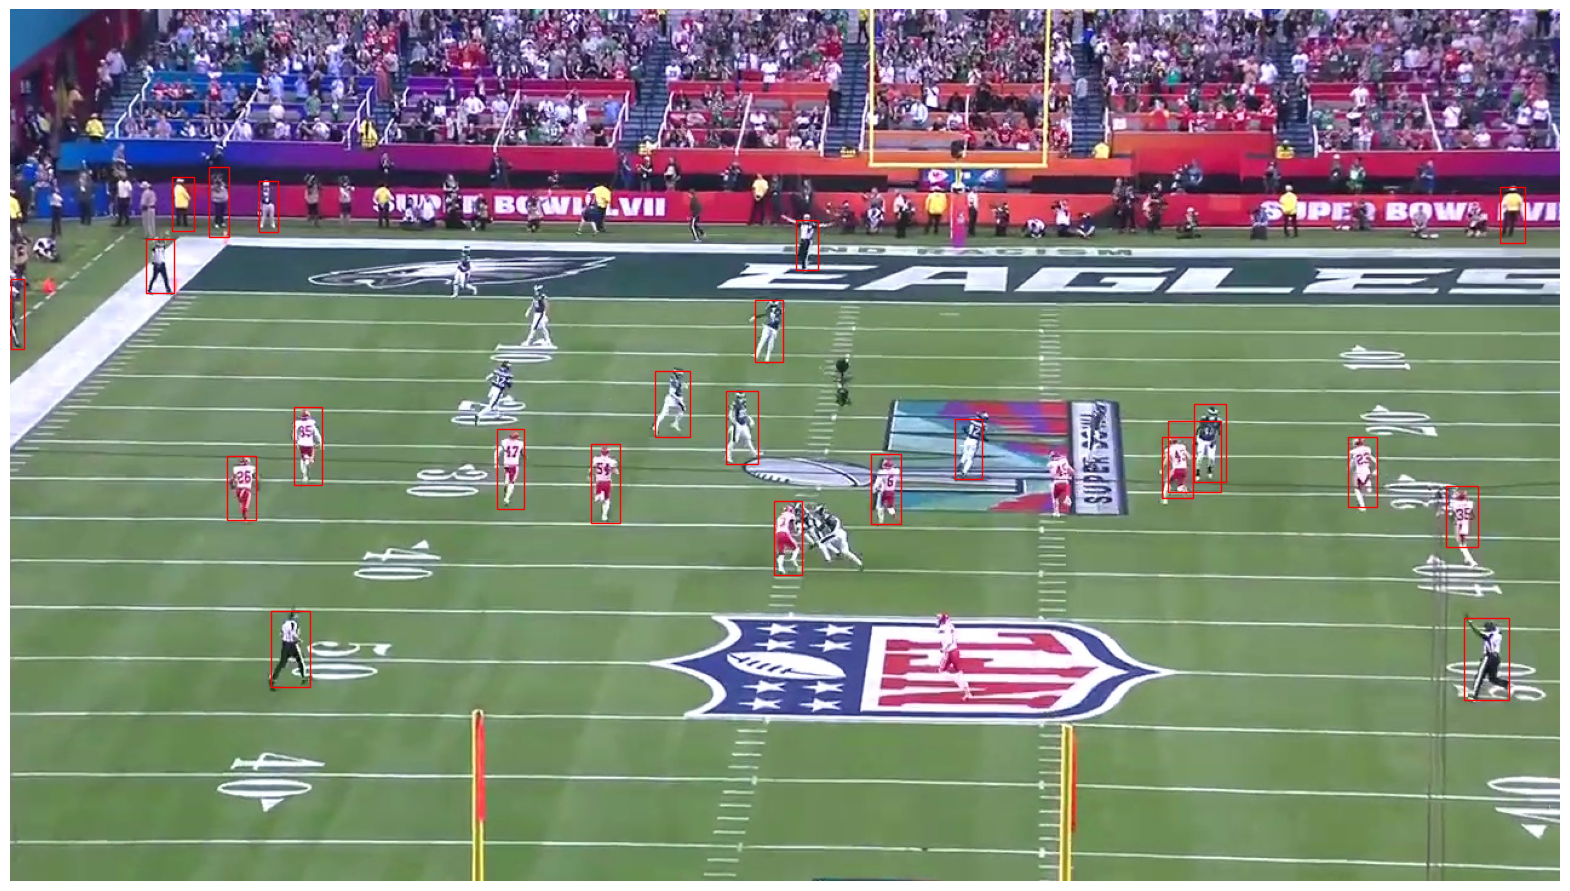

In [18]:
%matplotlib inline


def draw_boxes(image):
    df = pd.DataFrame(results.pandas().xyxy[image])
    img = cv2.imread(images[image])
    plt.figure(figsize=(20, 12))
    plt.imshow(Image.open(images[image]))
    plt.axis('off')
    for index, row in df.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
    
draw_boxes(image = 0)


Run on all images

In [60]:
images = []
folder_path = "frames"

for file_name in os.listdir(folder_path):
  file_path = os.path.join(folder_path, file_name)
  images.append(file_path)

In [61]:
results = model(images)
results.save()

players = []
accuracy = []

for i in results.pandas().xyxy:
    df = i
    players.append(sum(df['name'] == 'person'))
    accuracy.append(abs(sum(df['name'] == 'person') - 22) / 22)

Saved 1000 images to runs/detect/exp4


16.855 0.29740909090909046


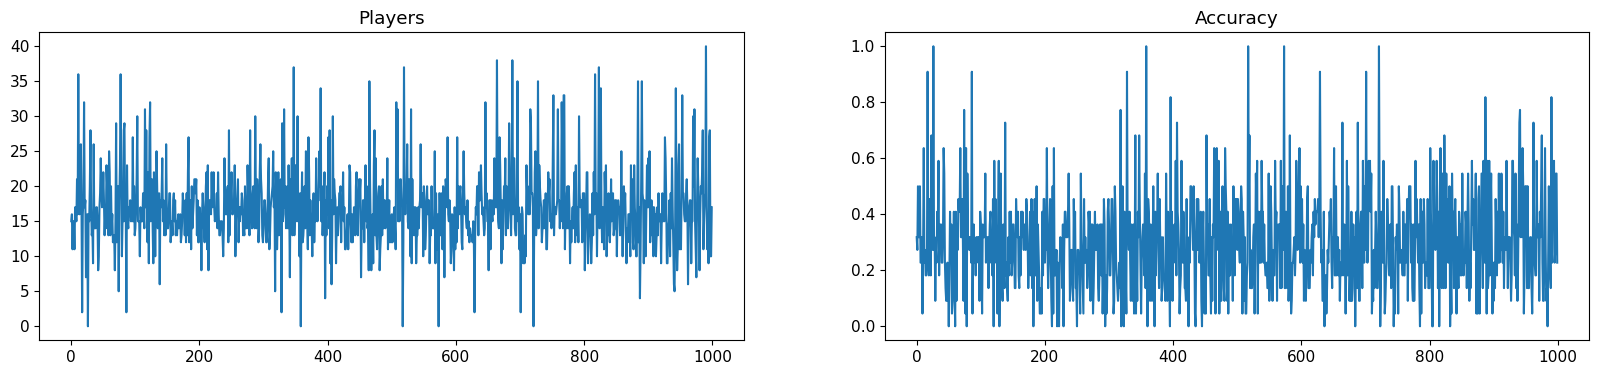

In [63]:
print(sum(players) / len(players), sum(accuracy) / len(accuracy))

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(players, label = "players"); ax[0].set_title("Players")
ax[1].plot(accuracy, label = "players"); ax[1].set_title("Accuracy")
plt.show()